In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using device: cuda
Found 1764 images
Found 1764 masks
Training samples: 1411
Validation samples: 353

Model initialized with 31043521 parameters

Starting training...
Epoch [1/10], Batch [0/353], Loss: 0.6498
Epoch [1/10], Batch [10/353], Loss: 0.6682
Epoch [1/10], Batch [20/353], Loss: 0.6262
Epoch [1/10], Batch [30/353], Loss: 0.6206
Epoch [1/10], Batch [40/353], Loss: 0.6358
Epoch [1/10], Batch [50/353], Loss: 0.6058
Epoch [1/10], Batch [60/353], Loss: 0.6578
Epoch [1/10], Batch [70/353], Loss: 0.5862
Epoch [1/10], Batch [80/353], Loss: 0.5723
Epoch [1/10], Batch [90/353], Loss: 0.5575
Epoch [1/10], Batch [100/353], Loss: 0.6048
Epoch [1/10], Batch [110/353], Loss: 0.6014
Epoch [1/10], Batch [120/353], Loss: 0.5465
Epoch [1/10], Batch [130/353], Loss: 0.7068
Epoch [1/10], Batch [140/353], Loss: 0.5981
Epoch [1/10], Batch [150/353], Loss: 0.5635
Epoch [1/10], Batch [160/353], Loss: 0.4795
Epoch [1/10], Batch [170/353], Loss: 0.6504
Epoch [1/10], Batch [180/353], Loss: 0.5100
Epoch [1

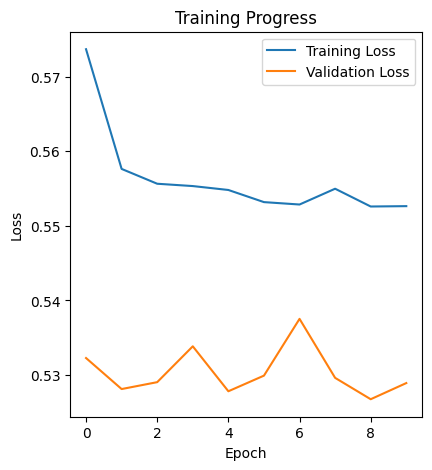

In [ ]:
# --- U-Net Implementation for Image Segmentation ---

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from pathlib import Path
import time

# --- Double Convolution Block ---
class DoubleConv(nn.Module):
    """Double convolution block used in U-Net"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

# --- U-Net Model ---
class UNet(nn.Module):
    """U-Net architecture implementation"""
    def __init__(self, n_channels=3, n_classes=1):
        super(UNet, self).__init__()
        # Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))
        # Decoder
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.conv1(x)
        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)
        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)
        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)
        return self.outc(x)

# --- Custom Dataset for Tiles ---
class TileDataset(Dataset):
    """Custom dataset for tile images"""
    def __init__(self, images_dir, masks_dir=None, transform=None, image_size=(256, 256)):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir) if masks_dir else None
        self.transform = transform
        self.image_size = image_size
        image_extensions = ["*.png", "*.jpg", "*.jpeg", "*.bmp", "*.tiff"]
        self.image_files = []
        for ext in image_extensions:
            self.image_files.extend(glob.glob(str(self.images_dir / ext)))
        self.image_files = sorted(self.image_files)
        if self.masks_dir and os.path.exists(self.masks_dir):
            self.mask_files = []
            for ext in image_extensions:
                self.mask_files.extend(glob.glob(str(self.masks_dir / ext)))
            self.mask_files = sorted(self.mask_files)
        else:
            self.mask_files = None
        print(f"Found {len(self.image_files)} images")
        if self.mask_files:
            print(f"Found {len(self.mask_files)} masks")
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        try:
            img_path = self.image_files[idx]
            image = Image.open(img_path).convert('RGB')
            image = image.resize(self.image_size, Image.LANCZOS)
            if self.mask_files and idx < len(self.mask_files):
                mask_path = self.mask_files[idx]
                mask = Image.open(mask_path).convert('L')
                mask = mask.resize(self.image_size, Image.LANCZOS)
                mask = np.array(mask, dtype=np.float32) / 255.0
            else:
                mask = np.zeros(self.image_size, dtype=np.float32)
            if self.transform:
                image = self.transform(image)
            else:
                image = transforms.ToTensor()(image)
            mask = torch.FloatTensor(mask).unsqueeze(0)
            return image, mask, os.path.basename(img_path)
        except Exception as e:
            print(f"Error loading image {idx}: {e}")
            dummy_image = torch.zeros(3, *self.image_size)
            dummy_mask = torch.zeros(1, *self.image_size)
            return dummy_image, dummy_mask, "error.png"

# --- Loss Functions ---
def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice

def combined_loss(pred, target, bce_weight=0.5):
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = dice_loss(pred, target)
    return bce_weight * bce + (1 - bce_weight) * dice

# --- Training Function ---
def train_unet(model, train_loader, val_loader=None, num_epochs=50, learning_rate=1e-3, device='cuda'):
    criterion = combined_loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    model.to(device)
    train_losses = []
    val_losses = []
    start_time = time.time()
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0
        num_batches = 0
        for batch_idx, (images, masks, _) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_batches += 1
            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
        avg_train_loss = running_loss / num_batches
        train_losses.append(avg_train_loss)
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, masks, _ in val_loader:
                    images, masks = images.to(device), masks.to(device)
                    outputs = model(images)
                    val_loss += criterion(outputs, masks).item()
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            scheduler.step(avg_val_loss)
            print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}')
        print(f"Epoch {epoch+1} took {time.time() - epoch_start:.2f} seconds")
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), f'unet_epoch_{epoch+1}.pth')
    print(f"Total training time: {(time.time() - start_time)/60:.2f} minutes")
    return train_losses, val_losses

# --- Prediction on Single Image ---
def predict_single_image(model, image_path, device='cuda', image_size=(256, 256)):
    model.eval()
    try:
        image = Image.open(image_path).convert('RGB')
        original_size = image.size
        image_resized = image.resize(image_size, Image.LANCZOS)
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        input_tensor = transform(image_resized).unsqueeze(0).to(device)
        with torch.no_grad():
            prediction = model(input_tensor)
            prediction = torch.sigmoid(prediction)
            prediction = prediction.squeeze().cpu().numpy()
        return prediction, image, image_resized, original_size
    except Exception as e:
        print(f"Error predicting image {image_path}: {e}")
        return None, None, None, None

# --- Visualization of Predictions ---
def visualize_predictions(model, dataset, device='cuda', num_samples=5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    for i in range(min(num_samples, len(dataset))):
        image, mask, filename = dataset[i]
        with torch.no_grad():
            input_tensor = image.unsqueeze(0).to(device)
            prediction = model(input_tensor)
            prediction = torch.sigmoid(prediction).squeeze().cpu().numpy()
        image_display = image.permute(1, 2, 0).cpu().numpy()
        image_display = image_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image_display = np.clip(image_display, 0, 1)
        axes[i, 0].imshow(image_display)
        axes[i, 0].set_title(f'Input: {filename}')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(prediction, cmap='gray')
        axes[i, 1].set_title('Prediction')
        axes[i, 1].axis('off')
        axes[i, 2].imshow(image_display)
        axes[i, 2].imshow(prediction, alpha=0.5, cmap='jet')
        axes[i, 2].set_title('Overlay')
        axes[i, 2].axis('off')
    plt.tight_layout()
    plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

# --- Main Execution ---
def main():
    IMAGES_DIR = r"/content/drive/MyDrive/Colab Notebooks/tiles"
    MASKS_DIR = r"/content/drive/MyDrive/Colab Notebooks/tiles/model_outputs/auto_masks"
    BATCH_SIZE = 4
    NUM_EPOCHS = 10
    LEARNING_RATE = 1e-4
    IMAGE_SIZE = (256, 256)
    VALIDATION_SPLIT = 0.2
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if not os.path.exists(IMAGES_DIR):
        print(f"Error: Images directory {IMAGES_DIR} does not exist!")
        return
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    dataset = TileDataset(
        images_dir=IMAGES_DIR,
        masks_dir=MASKS_DIR,
        transform=transform,
        image_size=IMAGE_SIZE
    )
    if len(dataset) == 0:
        print("No images found in the specified directory!")
        return
    if MASKS_DIR and os.path.exists(MASKS_DIR):
        train_size = int((1 - VALIDATION_SPLIT) * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
        print(f"Training samples: {len(train_dataset)}")
        print(f"Validation samples: {len(val_dataset)}")
    else:
        train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        val_loader = None
        print("No masks found - running in inference mode")
    model = UNet(n_channels=3, n_classes=1)
    print(f"\nModel initialized with {sum(p.numel() for p in model.parameters())} parameters")
    if MASKS_DIR and os.path.exists(MASKS_DIR):
        print("\nStarting training...")
        train_losses, val_losses = train_unet(
            model, train_loader, val_loader,
            NUM_EPOCHS, LEARNING_RATE, device
        )
        torch.save(model.state_dict(), 'unet_final.pth')
        print("Final model saved as 'unet_final.pth'")
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        if val_losses:
            plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training Progress')
        plt.savefig('training_curves.png')
        plt.show()
    else:
        print("\nRunning inference on sample images...")
        model_path = 'unet_final.pth'
        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path, map_location=device))
            print(f"Loaded pre-trained model from {model_path}")
        else:
            print("No pre-trained model found. Using randomly initialized weights.")
        model.to(device)
        visualize_predictions(model, dataset, device, num_samples=min(5, len(dataset)))
        tile_0_path = os.path.join(IMAGES_DIR, "tile_0.png")
        if os.path.exists(tile_0_path):
            print(f"\nMaking prediction on {tile_0_path}...")
            prediction, original, resized, orig_size = predict_single_image(
                model, tile_0_path, device, IMAGE_SIZE
            )
            if prediction is not None:
                print(f"Prediction shape: {prediction.shape}")
                print(f"Prediction range: [{prediction.min():.3f}, {prediction.max():.3f}]")
                pred_image = Image.fromarray((prediction * 255).astype(np.uint8))
                pred_image.save('tile_0_prediction.png')
                print("Prediction saved as 'tile_0_prediction.png'")

# For Jupyter/IPython, just call main() directly:
main()

Using device: cuda
Found 1764 images
Found 1764 masks
Training samples: 1411
Validation samples: 353

Model initialized with 31043521 parameters

Starting training...
Epoch [1/10], Batch [0/89], Loss: 0.5802
Epoch [1/10], Batch [10/89], Loss: 0.5482
Epoch [1/10], Batch [20/89], Loss: 0.5881
Epoch [1/10], Batch [30/89], Loss: 0.5551
Epoch [1/10], Batch [40/89], Loss: 0.5878
Epoch [1/10], Batch [50/89], Loss: 0.5163
Epoch [1/10], Batch [60/89], Loss: 0.5805
Epoch [1/10], Batch [70/89], Loss: 0.5183
Epoch [1/10], Batch [80/89], Loss: 0.5671
Epoch [1/10] - Train Loss: 0.5462, Val Loss: 0.5636
  Train IoU: 0.5298, Val IoU: 0.5024
  Train Acc: 0.5657, Val Acc: 0.5607
Epoch 1 took 342.41 seconds
Epoch [2/10], Batch [0/89], Loss: 0.5714
Epoch [2/10], Batch [10/89], Loss: 0.5369
Epoch [2/10], Batch [20/89], Loss: 0.5019
Epoch [2/10], Batch [30/89], Loss: 0.5824
Epoch [2/10], Batch [40/89], Loss: 0.5090
Epoch [2/10], Batch [50/89], Loss: 0.5356
Epoch [2/10], Batch [60/89], Loss: 0.5588
Epoch [2/

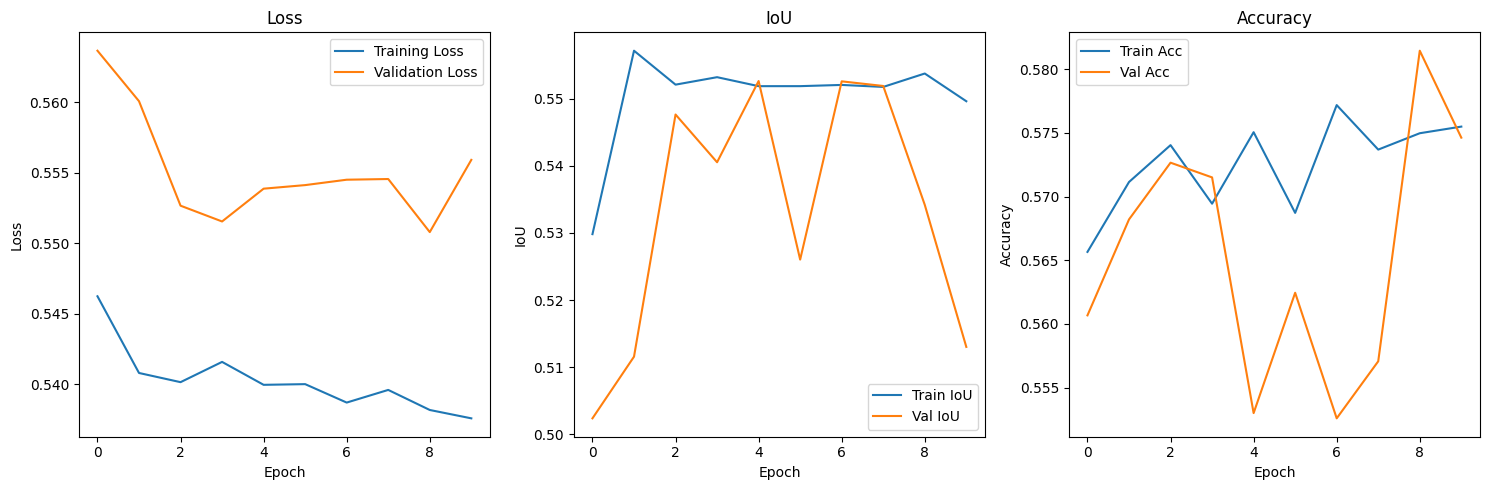

Best Validation IoU: 0.5526
Best Validation Accuracy: 0.5815


In [ ]:
# --- U-Net Implementation for Image Segmentation with Accuracy & IoU ---

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from pathlib import Path
import time

# --- Double Convolution Block ---
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

# --- U-Net Model ---
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.conv1(x)
        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)
        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)
        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)
        return self.outc(x)

# --- Custom Dataset for Tiles ---
class TileDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transform=None, image_size=(256, 256)):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir) if masks_dir else None
        self.transform = transform
        self.image_size = image_size
        image_extensions = ["*.png", "*.jpg", "*.jpeg", "*.bmp", "*.tiff"]
        self.image_files = []
        for ext in image_extensions:
            self.image_files.extend(glob.glob(str(self.images_dir / ext)))
        self.image_files = sorted(self.image_files)
        if self.masks_dir and os.path.exists(self.masks_dir):
            self.mask_files = []
            for ext in image_extensions:
                self.mask_files.extend(glob.glob(str(self.masks_dir / ext)))
            self.mask_files = sorted(self.mask_files)
        else:
            self.mask_files = None
        print(f"Found {len(self.image_files)} images")
        if self.mask_files:
            print(f"Found {len(self.mask_files)} masks")
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        try:
            img_path = self.image_files[idx]
            image = Image.open(img_path).convert('RGB')
            image = image.resize(self.image_size, Image.LANCZOS)
            if self.mask_files and idx < len(self.mask_files):
                mask_path = self.mask_files[idx]
                mask = Image.open(mask_path).convert('L')
                mask = mask.resize(self.image_size, Image.LANCZOS)
                mask = np.array(mask, dtype=np.float32) / 255.0
            else:
                mask = np.zeros(self.image_size, dtype=np.float32)
            if self.transform:
                image = self.transform(image)
            else:
                image = transforms.ToTensor()(image)
            mask = torch.FloatTensor(mask).unsqueeze(0)
            return image, mask, os.path.basename(img_path)
        except Exception as e:
            print(f"Error loading image {idx}: {e}")
            dummy_image = torch.zeros(3, *self.image_size)
            dummy_mask = torch.zeros(1, *self.image_size)
            return dummy_image, dummy_mask, "error.png"

# --- Metrics ---
def compute_iou(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    target = (target > threshold).float()
    intersection = (pred * target).sum()
    union = ((pred + target) > 0).float().sum()
    if union == 0:
        return float('nan')
    return (intersection / union).item()

def compute_accuracy(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    target = (target > threshold).float()
    correct = (pred == target).float().sum()
    total = torch.numel(pred)
    return (correct / total).item()

# --- Loss Functions ---
def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice

def combined_loss(pred, target, bce_weight=0.5):
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = dice_loss(pred, target)
    return bce_weight * bce + (1 - bce_weight) * dice

# --- Training Function ---
def train_unet(model, train_loader, val_loader=None, num_epochs=50, learning_rate=1e-3, device='cuda'):
    criterion = combined_loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    model.to(device)
    train_losses = []
    val_losses = []
    train_ious = []
    val_ious = []
    train_accs = []
    val_accs = []
    start_time = time.time()
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0
        running_iou = 0.0
        running_acc = 0.0
        num_batches = 0
        for batch_idx, (images, masks, _) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # Metrics
            preds = torch.sigmoid(outputs)
            running_iou += compute_iou(preds, masks)
            running_acc += compute_accuracy(preds, masks)
            num_batches += 1
            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
        avg_train_loss = running_loss / num_batches
        avg_train_iou = running_iou / num_batches
        avg_train_acc = running_acc / num_batches
        train_losses.append(avg_train_loss)
        train_ious.append(avg_train_iou)
        train_accs.append(avg_train_acc)
        if val_loader:
            model.eval()
            val_loss = 0.0
            val_iou = 0.0
            val_acc = 0.0
            with torch.no_grad():
                for images, masks, _ in val_loader:
                    images, masks = images.to(device), masks.to(device)
                    outputs = model(images)
                    val_loss += criterion(outputs, masks).item()
                    preds = torch.sigmoid(outputs)
                    val_iou += compute_iou(preds, masks)
                    val_acc += compute_accuracy(preds, masks)
            avg_val_loss = val_loss / len(val_loader)
            avg_val_iou = val_iou / len(val_loader)
            avg_val_acc = val_acc / len(val_loader)
            val_losses.append(avg_val_loss)
            val_ious.append(avg_val_iou)
            val_accs.append(avg_val_acc)
            scheduler.step(avg_val_loss)
            print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(f"  Train IoU: {avg_train_iou:.4f}, Val IoU: {avg_val_iou:.4f}")
            print(f"  Train Acc: {avg_train_acc:.4f}, Val Acc: {avg_val_acc:.4f}")
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}')
            print(f"  Train IoU: {avg_train_iou:.4f}")
            print(f"  Train Acc: {avg_train_acc:.4f}")
        print(f"Epoch {epoch+1} took {time.time() - epoch_start:.2f} seconds")
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), f'unet_epoch_{epoch+1}.pth')
    print(f"Total training time: {(time.time() - start_time)/60:.2f} minutes")
    return train_losses, val_losses, train_ious, val_ious, train_accs, val_accs

# --- Prediction on Single Image ---
def predict_single_image(model, image_path, device='cuda', image_size=(256, 256)):
    model.eval()
    try:
        image = Image.open(image_path).convert('RGB')
        original_size = image.size
        image_resized = image.resize(image_size, Image.LANCZOS)
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        input_tensor = transform(image_resized).unsqueeze(0).to(device)
        with torch.no_grad():
            prediction = model(input_tensor)
            prediction = torch.sigmoid(prediction)
            prediction = prediction.squeeze().cpu().numpy()
        return prediction, image, image_resized, original_size
    except Exception as e:
        print(f"Error predicting image {image_path}: {e}")
        return None, None, None, None

# --- Visualization of Predictions ---
def visualize_predictions(model, dataset, device='cuda', num_samples=5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    for i in range(min(num_samples, len(dataset))):
        image, mask, filename = dataset[i]
        with torch.no_grad():
            input_tensor = image.unsqueeze(0).to(device)
            prediction = model(input_tensor)
            prediction = torch.sigmoid(prediction).squeeze().cpu().numpy()
        image_display = image.permute(1, 2, 0).cpu().numpy()
        image_display = image_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image_display = np.clip(image_display, 0, 1)
        axes[i, 0].imshow(image_display)
        axes[i, 0].set_title(f'Input: {filename}')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(prediction, cmap='gray')
        axes[i, 1].set_title('Prediction')
        axes[i, 1].axis('off')
        axes[i, 2].imshow(image_display)
        axes[i, 2].imshow(prediction, alpha=0.5, cmap='jet')
        axes[i, 2].set_title('Overlay')
        axes[i, 2].axis('off')
    plt.tight_layout()
    plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

# --- Main Execution ---
def main():
    IMAGES_DIR = r"/content/drive/MyDrive/Colab Notebooks/tiles"
    MASKS_DIR = r"/content/drive/MyDrive/Colab Notebooks/tiles/model_outputs/auto_masks"
    BATCH_SIZE = 16
    NUM_EPOCHS = 10
    LEARNING_RATE = 1e-4
    IMAGE_SIZE = (256, 256)
    VALIDATION_SPLIT = 0.2
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if not os.path.exists(IMAGES_DIR):
        print(f"Error: Images directory {IMAGES_DIR} does not exist!")
        return
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    dataset = TileDataset(
        images_dir=IMAGES_DIR,
        masks_dir=MASKS_DIR,
        transform=transform,
        image_size=IMAGE_SIZE
    )
    if len(dataset) == 0:
        print("No images found in the specified directory!")
        return
    if MASKS_DIR and os.path.exists(MASKS_DIR):
        train_size = int((1 - VALIDATION_SPLIT) * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
        print(f"Training samples: {len(train_dataset)}")
        print(f"Validation samples: {len(val_dataset)}")
    else:
        train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        val_loader = None
        print("No masks found - running in inference mode")
    model = UNet(n_channels=3, n_classes=1)
    print(f"\nModel initialized with {sum(p.numel() for p in model.parameters())} parameters")
    if MASKS_DIR and os.path.exists(MASKS_DIR):
        print("\nStarting training...")
        train_losses, val_losses, train_ious, val_ious, train_accs, val_accs = train_unet(
            model, train_loader, val_loader,
            NUM_EPOCHS, LEARNING_RATE, device
        )
        torch.save(model.state_dict(), 'unet_final.pth')
        print("Final model saved as 'unet_final.pth'")
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Training Loss')
        if val_losses:
            plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss')
        plt.subplot(1, 3, 2)
        plt.plot(train_ious, label='Train IoU')
        if val_ious:
            plt.plot(val_ious, label='Val IoU')
        plt.xlabel('Epoch')
        plt.ylabel('IoU')
        plt.legend()
        plt.title('IoU')
        plt.subplot(1, 3, 3)
        plt.plot(train_accs, label='Train Acc')
        if val_accs:
            plt.plot(val_accs, label='Val Acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy')
        plt.tight_layout()
        plt.savefig('training_metrics.png')
        plt.show()
        print(f"Best Validation IoU: {np.nanmax(val_ious):.4f}")
        print(f"Best Validation Accuracy: {np.nanmax(val_accs):.4f}")
    else:
        print("\nRunning inference on sample images...")
        model_path = 'unet_final.pth'
        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path, map_location=device))
            print(f"Loaded pre-trained model from {model_path}")
        else:
            print("No pre-trained model found. Using randomly initialized weights.")
        model.to(device)
        visualize_predictions(model, dataset, device, num_samples=min(5, len(dataset)))
        tile_0_path = os.path.join(IMAGES_DIR, "tile_0.png")
        if os.path.exists(tile_0_path):
            print(f"\nMaking prediction on {tile_0_path}...")
            prediction, original, resized, orig_size = predict_single_image(
                model, tile_0_path, device, IMAGE_SIZE
            )
            if prediction is not None:
                print(f"Prediction shape: {prediction.shape}")
                print(f"Prediction range: [{prediction.min():.3f}, {prediction.max():.3f}]")
                pred_image = Image.fromarray((prediction * 255).astype(np.uint8))
                pred_image.save('tile_0_prediction.png')
                print("Prediction saved as 'tile_0_prediction.png'")

# For Jupyter/IPython, just call main() directly:
main()

In [ ]:
# --- U-Net Implementation with Improvements for Higher Accuracy ---

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
import os, glob, time
from pathlib import Path
import matplotlib.pyplot as plt

# --- Double Convolution with Dropout ---
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

# --- U-Net Model ---
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5)
        x = torch.cat([x4, x], dim=1); x = self.conv1(x)
        x = self.up2(x); x = torch.cat([x3, x], dim=1); x = self.conv2(x)
        x = self.up3(x); x = torch.cat([x2, x], dim=1); x = self.conv3(x)
        x = self.up4(x); x = torch.cat([x1, x], dim=1); x = self.conv4(x)
        return self.outc(x)

# --- Dataset with Albumentations ---
class TileDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, image_size=(256,256), augment=False):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir) if masks_dir else None
        self.image_size = image_size
        self.augment = augment

        exts = ["*.png", "*.jpg", "*.jpeg", "*.bmp", "*.tiff"]
        self.image_files = sorted([f for ext in exts for f in glob.glob(str(self.images_dir/ext))])
        self.mask_files = sorted([f for ext in exts for f in glob.glob(str(self.masks_dir/ext))]) if self.masks_dir else None

        self.transform = A.Compose([
            A.Resize(*image_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussianBlur(p=0.2),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2()
        ]) if augment else A.Compose([
            A.Resize(*image_size),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2()
        ])
        print(f"Found {len(self.image_files)} images, {len(self.mask_files) if self.mask_files else 0} masks")

    def __len__(self): return len(self.image_files)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.image_files[idx]).convert('RGB'))
        mask = np.zeros(self.image_size) if not self.mask_files else np.array(Image.open(self.mask_files[idx]).convert('L'))
        augmented = self.transform(image=img, mask=mask)
        return augmented['image'], augmented['mask'].unsqueeze(0).float(), os.path.basename(self.image_files[idx])

# --- Losses ---
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred*target).sum()
    return 1 - ((2*intersection+smooth) / (pred.sum()+target.sum()+smooth))

class ComboLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.alpha, self.gamma = alpha, gamma
    def forward(self, preds, targets):
        bce = self.bce(preds, targets)
        dsc = dice_loss(preds, targets)
        pt = torch.sigmoid(preds)
        focal = -self.alpha*(targets*(1-pt)**self.gamma*torch.log(pt+1e-6) + (1-targets)*pt**self.gamma*torch.log(1-pt+1e-6)).mean()
        return 0.5*bce + 0.5*dsc + 0.5*focal

# --- Training ---
def train_unet(model, train_loader, val_loader, epochs=30, lr=1e-4, device='cuda'):
    criterion = ComboLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    scaler = torch.amp.GradScaler("cuda")
    model.to(device)

    best_iou, history = 0, {'train_loss':[], 'val_loss':[], 'val_iou':[]}

    for epoch in range(epochs):
        model.train(); running_loss=0
        for images, masks, _ in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
            running_loss += loss.item()
        scheduler.step()

        # Validation
        model.eval(); val_loss, val_iou = 0, 0
        with torch.no_grad():
            for images, masks, _ in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()
                preds = (torch.sigmoid(outputs)>0.5).float()
                intersection = (preds*masks).sum(); union = ((preds+masks)>0).sum()
                val_iou += (intersection/union).item() if union>0 else 0
        avg_loss = running_loss/len(train_loader); avg_val_loss=val_loss/len(val_loader); avg_val_iou=val_iou/len(val_loader)

        history['train_loss'].append(avg_loss); history['val_loss'].append(avg_val_loss); history['val_iou'].append(avg_val_iou)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}")

        if avg_val_iou>best_iou:
            best_iou=avg_val_iou; torch.save(model.state_dict(),"best_unet.pth"); print("✅ Best model saved!")

    return history


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from pathlib import Path
import time


# --- LinkNet Blocks ---
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Conv2d(in_channels, out_channels, 1, bias=False) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        return out


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels // 4)
        self.relu = nn.ReLU(inplace=True)
        self.deconv2 = nn.ConvTranspose2d(
            in_channels // 4, in_channels // 4, 3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_channels // 4)
        self.conv3 = nn.Conv2d(in_channels // 4, out_channels, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.deconv2(out)))
        out = self.relu(self.bn3(self.conv3(out)))
        return out


class LinkNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(LinkNet, self).__init__()
        self.in_block = nn.Sequential(
            nn.Conv2d(n_channels, 64, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)
        self.enc1 = EncoderBlock(64, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)
        self.dec4 = DecoderBlock(512, 256)
        self.dec3 = DecoderBlock(256, 128)
        self.dec2 = DecoderBlock(128, 64)
        self.dec1 = DecoderBlock(64, 64)
        self.finaldeconv1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1, bias=False)
        self.finalrelu1 = nn.ReLU(inplace=True)
        self.finalconv2 = nn.Conv2d(32, 32, 3, padding=1, bias=False)
        self.finalrelu2 = nn.ReLU(inplace=True)
        # FIX: kernel_size=1, padding=0 to keep output size same as input size (256x256)
        self.finalconv3 = nn.Conv2d(32, n_classes, 1, padding=0)

    def forward(self, x):
        x = self.in_block(x)
        x = self.pool(x)
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        d4 = self._upsample_add(self.dec4(e4), e3)
        d3 = self._upsample_add(self.dec3(d4), e2)
        d2 = self._upsample_add(self.dec2(d3), e1)
        d1 = self.dec1(d2)
        out = self.finaldeconv1(d1)
        out = self.finalrelu1(out)
        out = self.finalconv2(out)
        out = self.finalrelu2(out)
        out = self.finalconv3(out)
        return out

    def _upsample_add(self, x, y):
        if x.shape[2:] != y.shape[2:]:
            x = nn.functional.interpolate(x, size=y.shape[2:], mode='bilinear', align_corners=False)
        return x + y


# The rest of the code (dataset, metrics, loss, training, etc.) remains the same as in previous versions but ensure to check mask and image resizing to 256x256 exactly.

# Test the model output size with dummy tensor:
if __name__ == "__main__":
    model = LinkNet()
    dummy_input = torch.randn(1, 3, 256, 256)
    output = model(dummy_input)
    print(f"Model output shape: {output.shape}")  # Expected: torch.Size([1, 1, 256, 256])


Model output shape: torch.Size([1, 1, 256, 256])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
import glob
import time

# Encoder and Decoder blocks from LinkNet (same as before)...

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Conv2d(in_channels, out_channels, 1, bias=False) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        return out


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels // 4)
        self.relu = nn.ReLU(inplace=True)
        self.deconv2 = nn.ConvTranspose2d(
            in_channels // 4, in_channels // 4, 3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_channels // 4)
        self.conv3 = nn.Conv2d(in_channels // 4, out_channels, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.deconv2(out)))
        out = self.relu(self.bn3(self.conv3(out)))
        return out


class LinkNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.in_block = nn.Sequential(
            nn.Conv2d(n_channels, 64, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(3, 2, 1)
        self.enc1 = EncoderBlock(64, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)
        self.dec4 = DecoderBlock(512, 256)
        self.dec3 = DecoderBlock(256, 128)
        self.dec2 = DecoderBlock(128, 64)
        self.dec1 = DecoderBlock(64, 64)
        self.finaldeconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1, bias=False)
        self.finalrelu1 = nn.ReLU(inplace=True)
        self.finalconv2 = nn.Conv2d(32, 32, 3, padding=1, bias=False)
        self.finalrelu2 = nn.ReLU(inplace=True)
        self.finalconv3 = nn.Conv2d(32, n_classes, 1, padding=0)  # kernel size 1 for same size output

    def forward(self, x):
        x = self.in_block(x)
        x = self.pool(x)
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        d4 = self._upsample_add(self.dec4(e4), e3)
        d3 = self._upsample_add(self.dec3(d4), e2)
        d2 = self._upsample_add(self.dec2(d3), e1)
        d1 = self.dec1(d2)
        out = self.finaldeconv1(d1)
        out = self.finalrelu1(out)
        out = self.finalconv2(out)
        out = self.finalrelu2(out)
        out = self.finalconv3(out)
        return out

    def _upsample_add(self, x, y):
        if x.shape[2:] != y.shape[2:]:
            x = nn.functional.interpolate(x, size=y.shape[2:], mode='bilinear', align_corners=False)
        return x + y


class TileDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, image_size=(256, 256)):
        self.images = sorted(glob.glob(os.path.join(images_dir, "*.*")))
        self.masks = sorted(glob.glob(os.path.join(masks_dir, "*.*")))
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('RGB').resize(self.image_size, Image.LANCZOS)
        mask = Image.open(self.masks[idx]).convert('L').resize(self.image_size, Image.LANCZOS)
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        mask = np.array(mask, dtype=np.float32) / 255.0
        mask = torch.FloatTensor(mask).unsqueeze(0)
        return img, mask


def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    dice = (2 * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice


def combined_loss(pred, target, bce_weight=0.5):
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = dice_loss(pred, target)
    return bce_weight * bce + (1 - bce_weight) * dice


def compute_iou(pred, target, threshold=0.5):
    pred = (pred > threshold).astype(np.uint8)
    target = (target > threshold).astype(np.uint8)
    intersection = np.logical_and(pred, target).sum()
    union = np.logical_or(pred, target).sum()
    if union == 0:
        return float('nan')
    return intersection / union


def compute_accuracy(pred, target, threshold=0.5):
    pred = (pred > threshold).astype(np.uint8)
    target = (target > threshold).astype(np.uint8)
    return (pred == target).sum() / pred.size


def train_linknet(model, train_loader, val_loader=None, epochs=10, lr=1e-4, device='cuda'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_iou = 0
        train_acc = 0
        batches = 0

        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)

            loss = combined_loss(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            masks_np = masks.detach().cpu().numpy()
            train_iou += compute_iou(preds, masks_np)
            train_acc += compute_accuracy(preds, masks_np)
            batches += 1

        avg_loss = train_loss / batches
        avg_iou = train_iou / batches
        avg_acc = train_acc / batches

        if val_loader:
            model.eval()
            val_loss = 0
            val_iou = 0
            val_acc = 0
            val_batches = 0
            with torch.no_grad():
                for imgs, masks in val_loader:
                    imgs, masks = imgs.to(device), masks.to(device)
                    outputs = model(imgs)
                    loss = combined_loss(outputs, masks)
                    val_loss += loss.item()

                    preds = torch.sigmoid(outputs).cpu().numpy()
                    masks_np = masks.cpu().numpy()
                    val_iou += compute_iou(preds, masks_np)
                    val_acc += compute_accuracy(preds, masks_np)
                    val_batches += 1
            avg_val_loss = val_loss / val_batches
            avg_val_iou = val_iou / val_batches
            avg_val_acc = val_acc / val_batches

            print(f"Epoch {epoch+1}/{epochs}  Train Loss:{avg_loss:.4f}  Val Loss:{avg_val_loss:.4f}")
            print(f"Train IoU: {avg_iou:.4f}  Val IoU: {avg_val_iou:.4f}")
            print(f"Train Acc: {avg_acc:.4f}  Val Acc: {avg_val_acc:.4f}")

            scheduler.step(avg_val_loss)
        else:
            print(f"Epoch {epoch+1}/{epochs}  Train Loss:{avg_loss:.4f}")
            print(f"Train IoU: {avg_iou:.4f}")
            print(f"Train Acc: {avg_acc:.4f}")

    torch.save(model.state_dict(), "linknet_final.pth")
    print("Saved model as linknet_final.pth")


def main():
    images_dir = "/content/drive/MyDrive/Colab Notebooks/tiles"
    masks_dir = "/content/drive/MyDrive/Colab Notebooks/tiles/model_outputs/auto_masks"
    batch_size = 4
    epochs = 10
    lr = 1e-4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    dataset = TileDataset(images_dir, masks_dir, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    model = LinkNet(n_channels=3, n_classes=1)

    train_linknet(model, train_loader, val_loader, epochs, lr, device)


if __name__ == "__main__":
    main()


Epoch 1/10  Train Loss:0.5564  Val Loss:0.5470
Train IoU: 0.5308  Val IoU: 0.5586
Train Acc: 0.5539  Val Acc: 0.5586
Epoch 2/10  Train Loss:0.5494  Val Loss:0.5488
Train IoU: 0.5607  Val IoU: 0.5586
Train Acc: 0.5607  Val Acc: 0.5586
Epoch 3/10  Train Loss:0.5494  Val Loss:0.5457
Train IoU: 0.5607  Val IoU: 0.5586
Train Acc: 0.5607  Val Acc: 0.5586
Epoch 4/10  Train Loss:0.5503  Val Loss:0.5456
Train IoU: 0.5607  Val IoU: 0.5586
Train Acc: 0.5607  Val Acc: 0.5586
Epoch 5/10  Train Loss:0.5478  Val Loss:0.5463
Train IoU: 0.5607  Val IoU: 0.5586
Train Acc: 0.5607  Val Acc: 0.5586
Epoch 6/10  Train Loss:0.5481  Val Loss:0.5453
Train IoU: 0.5607  Val IoU: 0.5586
Train Acc: 0.5607  Val Acc: 0.5586
Epoch 7/10  Train Loss:0.5483  Val Loss:0.5473
Train IoU: 0.5607  Val IoU: 0.5586
Train Acc: 0.5607  Val Acc: 0.5586
Epoch 8/10  Train Loss:0.5464  Val Loss:0.5447
Train IoU: 0.5607  Val IoU: 0.5586
Train Acc: 0.5607  Val Acc: 0.5586
Epoch 9/10  Train Loss:0.5468  Val Loss:0.5433
Train IoU: 0.5607

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from PIL import Image
import numpy as np
import glob
import os

# Custom Dataset for loading images and masks
class TileDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, image_size=(256, 256)):
        self.image_files = sorted(glob.glob(os.path.join(images_dir, "*.*")))
        self.mask_files = sorted(glob.glob(os.path.join(masks_dir, "*.*")))
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert('RGB').resize(self.image_size, Image.LANCZOS)
        mask = Image.open(self.mask_files[idx]).convert('L').resize(self.image_size, Image.LANCZOS)
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        mask = np.array(mask, dtype=np.float32)/255.0
        mask = torch.FloatTensor(mask).unsqueeze(0)
        return image, mask

# Dice loss function
def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    dice = (2.*intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice

# Combined loss: BCE + Dice
def combined_loss(pred, target, bce_weight=0.5):
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = dice_loss(pred, target)
    return bce_weight * bce + (1-bce_weight) * dice

def train_deeplabv3_plus(model, train_loader, val_loader=None, epochs=10, lr=1e-4, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)['out']  # 'out' key contains the segmentation logits
            loss = combined_loss(outputs, masks)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} Training Loss: {avg_loss:.4f}")

        if val_loader:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(device), masks.to(device)
                    outputs = model(images)['out']
                    loss = combined_loss(outputs, masks)
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_loader)
            print(f"Epoch {epoch+1}/{epochs} Validation Loss: {avg_val_loss:.4f}")
            scheduler.step(avg_val_loss)

    torch.save(model.state_dict(), "deeplabv3_plus_final.pth")
    print("Model saved as deeplabv3_plus_final.pth")


def main():
    images_dir = "/content/drive/MyDrive/Colab Notebooks/tiles"
    masks_dir = "/content/drive/MyDrive/Colab Notebooks/tiles/model_outputs/auto_masks"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 16
    epochs = 10

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

    dataset = TileDataset(images_dir, masks_dir, transform=transform, image_size=(256, 256))
    val_len = int(0.2 * len(dataset))
    train_len = len(dataset) - val_len
    train_ds, val_ds = random_split(dataset, [train_len, val_len])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    # Load pretrained DeepLabV3+ with ResNet50 backbone
    model = deeplabv3_resnet50(weights='DEFAULT')

    # Modify classifier for 1 class (binary segmentation)
    model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
    model.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

    train_deeplabv3_plus(model, train_loader, val_loader, epochs, lr=1e-4, device=device)


if __name__ == "__main__":
    main()


Epoch 1/10 Training Loss: 0.5585
Epoch 1/10 Validation Loss: 0.5431
Epoch 2/10 Training Loss: 0.5367
Epoch 2/10 Validation Loss: 0.5447
Epoch 3/10 Training Loss: 0.5334
Epoch 3/10 Validation Loss: 0.5318
Epoch 4/10 Training Loss: 0.5248
Epoch 4/10 Validation Loss: 0.5426
Epoch 5/10 Training Loss: 0.5193
Epoch 5/10 Validation Loss: 0.5320
Epoch 6/10 Training Loss: 0.5138
Epoch 6/10 Validation Loss: 0.5617
Epoch 7/10 Training Loss: 0.4924
Epoch 7/10 Validation Loss: 0.5652
Epoch 8/10 Training Loss: 0.4765
Epoch 8/10 Validation Loss: 0.5543
Epoch 9/10 Training Loss: 0.4663
Epoch 9/10 Validation Loss: 0.5461
Epoch 10/10 Training Loss: 0.4570
Epoch 10/10 Validation Loss: 0.5409
Model saved as deeplabv3_plus_final.pth


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from PIL import Image
import numpy as np
import glob
import os
import random
import torchvision.transforms.functional as TF

# ---------------------------
# Dataset with augmentation
# ---------------------------
class TileDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_size=(256, 256), augment=False):
        self.image_files = sorted(glob.glob(os.path.join(images_dir, "*.*")))
        self.mask_files = sorted(glob.glob(os.path.join(masks_dir, "*.*")))
        self.image_size = image_size
        self.augment = augment

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert("RGB").resize(self.image_size, Image.LANCZOS)
        mask = Image.open(self.mask_files[idx]).convert("L").resize(self.image_size, Image.LANCZOS)

        # Augmentations
        if self.augment:
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            if random.random() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
            if random.random() > 0.5:
                angle = random.randint(-15, 15)
                image = TF.rotate(image, angle)
                mask = TF.rotate(mask, angle)

        # Convert to tensor + normalize
        image = transforms.ToTensor()(image)
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])(image)
        mask = torch.FloatTensor(np.array(mask, dtype=np.float32) / 255.0).unsqueeze(0)

        return image, mask


# ---------------------------
# Loss Functions
# ---------------------------
def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice

def combined_loss(pred, target, bce_weight=0.7):
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = dice_loss(pred, target)
    return bce_weight * bce + (1 - bce_weight) * dice


# ---------------------------
# Metrics
# ---------------------------
def compute_iou(pred, target, threshold=0.5):
    pred = (pred > threshold).cpu().numpy().astype(np.uint8)
    target = (target > threshold).cpu().numpy().astype(np.uint8)
    intersection = np.logical_and(pred, target).sum()
    union = np.logical_or(pred, target).sum()
    return float(intersection)/union if union != 0 else float('nan')

def compute_accuracy(pred, target, threshold=0.5):
    pred = (pred > threshold).cpu().numpy().astype(np.uint8)
    target = (target > threshold).cpu().numpy().astype(np.uint8)
    return (pred == target).sum() / pred.size


# ---------------------------
# Training Loop (with AMP + LR scheduler)
# ---------------------------
def train_deeplabv3_plus(model, train_loader, val_loader=None,
                         epochs=50, lr=1e-3, weight_decay=1e-5,
                         bce_weight=0.7, device='cuda'):

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    scaler = torch.cuda.amp.GradScaler()

    # Unfreeze backbone after 5 epochs
    unfreeze_epoch = 5

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        if epoch == unfreeze_epoch:
            print("Unfreezing backbone for fine-tuning...")
            for param in model.backbone.parameters():
                param.requires_grad = True

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(images)['out']
                loss = combined_loss(outputs, masks, bce_weight=bce_weight)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} Train Loss: {avg_loss:.4f}")

        if val_loader:
            model.eval()
            val_loss, val_iou, val_acc = 0, 0, 0
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(device), masks.to(device)
                    outputs = model(images)['out']
                    loss = combined_loss(outputs, masks, bce_weight=bce_weight)
                    val_loss += loss.item()
                    preds = torch.sigmoid(outputs)
                    val_iou += compute_iou(preds, masks)
                    val_acc += compute_accuracy(preds, masks)

            avg_val_loss = val_loss / len(val_loader)
            avg_val_iou = val_iou / len(val_loader)
            avg_val_acc = val_acc / len(val_loader)
            print(f"Epoch {epoch+1}/{epochs} Val Loss: {avg_val_loss:.4f} IoU: {avg_val_iou:.4f} Accuracy: {avg_val_acc:.4f}")
            scheduler.step(avg_val_loss)

    torch.save(model.state_dict(), "deeplabv3_plus_final.pth")
    print("✅ Model saved as deeplabv3_plus_final.pth")


# ---------------------------
# Main
# ---------------------------
def main():
    images_dir = "/content/drive/MyDrive/Colab Notebooks/tiles"
    masks_dir = "/content/drive/MyDrive/Colab Notebooks/tiles/model_outputs/auto_masks"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 16
    epochs = 50  # longer training

    dataset = TileDataset(images_dir, masks_dir, image_size=(256, 256), augment=True)
    val_count = int(0.2 * len(dataset))
    train_count = len(dataset) - val_count
    train_ds, val_ds = random_split(dataset, [train_count, val_count])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    model = deeplabv3_resnet50(weights='DEFAULT')
    model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
    model.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

    train_deeplabv3_plus(model, train_loader, val_loader,
                         epochs=epochs, lr=1e-3,
                         weight_decay=1e-5, bce_weight=0.7, device=device)


if __name__ == "__main__":
    main()


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:00<00:00, 184MB/s]
/tmp/ipython-input-3100491377.py:94: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-3100491377.py:112: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/50 Train Loss: 0.6020
Epoch 1/50 Val Loss: 0.6237 IoU: 0.4100 Accuracy: 0.5434
Epoch 2/50 Train Loss: 0.5881
Epoch 2/50 Val Loss: 0.6073 IoU: 0.5145 Accuracy: 0.5760
Epoch 3/50 Train Loss: 0.5883
Epoch 3/50 Val Loss: 0.6001 IoU: 0.5009 Accuracy: 0.5790
Epoch 4/50 Train Loss: 0.5864
Epoch 4/50 Val Loss: 0.6201 IoU: 0.5645 Accuracy: 0.5794
Epoch 5/50 Train Loss: 0.5854
Epoch 5/50 Val Loss: 0.5974 IoU: 0.4838 Accuracy: 0.5860
Unfreezing backbone for fine-tuning...
Epoch 6/50 Train Loss: 0.5897
Epoch 6/50 Val Loss: 0.5933 IoU: 0.5356 Accuracy: 0.5849
Epoch 7/50 Train Loss: 0.5868
Epoch 7/50 Val Loss: 0.5953 IoU: 0.5233 Accuracy: 0.5867
Epoch 8/50 Train Loss: 0.5852
Epoch 8/50 Val Loss: 0.5881 IoU: 0.5067 Accuracy: 0.5904
Epoch 9/50 Train Loss: 0.5886
Epoch 9/50 Val Loss: 0.5945 IoU: 0.4755 Accuracy: 0.5726
Epoch 10/50 Train Loss: 0.5842
Epoch 10/50 Val Loss: 0.5890 IoU: 0.5041 Accuracy: 0.5885
Epoch 11/50 Train Loss: 0.5822
Epoch 11/50 Val Loss: 0.6074 IoU: 0.5332 Accuracy: 0.5891


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from PIL import Image
import numpy as np
import glob, os, random
import torchvision.transforms.functional as TF
from itertools import product

# ---------------------------
# Dataset with augmentation
# ---------------------------
class TileDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_size=(256, 256), augment=False):
        self.image_files = sorted(glob.glob(os.path.join(images_dir, "*.*")))
        self.mask_files = sorted(glob.glob(os.path.join(masks_dir, "*.*")))
        self.image_size = image_size
        self.augment = augment

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert("RGB").resize(self.image_size, Image.LANCZOS)
        mask = Image.open(self.mask_files[idx]).convert("L").resize(self.image_size, Image.LANCZOS)

        # Augmentations
        if self.augment:
            if random.random() > 0.5:
                image = TF.hflip(image); mask = TF.hflip(mask)
            if random.random() > 0.5:
                image = TF.vflip(image); mask = TF.vflip(mask)
            if random.random() > 0.5:
                angle = random.randint(-15, 15)
                image = TF.rotate(image, angle); mask = TF.rotate(mask, angle)

        # Convert to tensor + normalize
        image = transforms.ToTensor()(image)
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])(image)
        mask = torch.FloatTensor(np.array(mask, dtype=np.float32) / 255.0).unsqueeze(0)

        return image, mask


# ---------------------------
# Loss Functions
# ---------------------------
def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice

def combined_loss(pred, target, bce_weight=0.7):
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = dice_loss(pred, target)
    return bce_weight * bce + (1 - bce_weight) * dice


# ---------------------------
# Metrics
# ---------------------------
def compute_iou(pred, target, threshold=0.5):
    pred = (pred > threshold).cpu().numpy().astype(np.uint8)
    target = (target > threshold).cpu().numpy().astype(np.uint8)
    intersection = np.logical_and(pred, target).sum()
    union = np.logical_or(pred, target).sum()
    return float(intersection)/union if union != 0 else float('nan')

def compute_accuracy(pred, target, threshold=0.5):
    pred = (pred > threshold).cpu().numpy().astype(np.uint8)
    target = (target > threshold).cpu().numpy().astype(np.uint8)
    return (pred == target).sum() / pred.size


# ---------------------------
# Training Loop (with AMP + scheduler)
# ---------------------------
def train_deeplabv3_plus(model, train_loader, val_loader,
                         epochs=30, lr=1e-3, weight_decay=1e-5,
                         bce_weight=0.7, device='cuda', run_name="exp"):

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    scaler = torch.cuda.amp.GradScaler()

    # Freeze backbone first, unfreeze later
    for param in model.backbone.parameters():
        param.requires_grad = False
    unfreeze_epoch = 5

    best_val_iou = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        if epoch == unfreeze_epoch:
            print("🔓 Unfreezing backbone...")
            for param in model.backbone.parameters():
                param.requires_grad = True

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(images)['out']
                loss = combined_loss(outputs, masks, bce_weight=bce_weight)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"[{run_name}] Epoch {epoch+1}/{epochs} Train Loss: {avg_loss:.4f}")

        # Validation
        model.eval()
        val_loss, val_iou, val_acc = 0, 0, 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)['out']
                loss = combined_loss(outputs, masks, bce_weight=bce_weight)
                val_loss += loss.item()
                preds = torch.sigmoid(outputs)
                val_iou += compute_iou(preds, masks)
                val_acc += compute_accuracy(preds, masks)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)
        print(f"[{run_name}] Val Loss: {avg_val_loss:.4f} IoU: {avg_val_iou:.4f} Acc: {avg_val_acc:.4f}")

        scheduler.step(avg_val_loss)

        # Save best model for this run
        if avg_val_iou > best_val_iou:
            best_val_iou = avg_val_iou
            save_path = f"deeplabv3_plus_{run_name}_best.pth"
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved best model ({save_path}) with IoU={best_val_iou:.4f}")

    return best_val_iou


# ---------------------------
# Hyperparameter Search
# ---------------------------
def main():
    images_dir = "/content/drive/MyDrive/Colab Notebooks/tiles"
    masks_dir = "/content/drive/MyDrive/Colab Notebooks/tiles/model_outputs/auto_masks"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 16
    epochs = 30  # reduce for faster search

    dataset = TileDataset(images_dir, masks_dir, image_size=(256, 256), augment=True)
    val_count = int(0.2 * len(dataset))
    train_count = len(dataset) - val_count
    train_ds, val_ds = random_split(dataset, [train_count, val_count])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    # Hyperparameter grid
    lrs = [1e-3, 5e-4]
    weight_decays = [1e-5, 1e-6]
    bce_weights = [0.5, 0.7]

    results = {}

    for lr, wd, bw in product(lrs, weight_decays, bce_weights):
        run_name = f"lr{lr}_wd{wd}_bw{bw}"
        print(f"\n🚀 Starting run: {run_name}")

        model = deeplabv3_resnet50(weights='DEFAULT')
        model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
        model.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

        best_iou = train_deeplabv3_plus(model, train_loader, val_loader,
                                        epochs=epochs, lr=lr, weight_decay=wd,
                                        bce_weight=bw, device=device, run_name=run_name)
        results[run_name] = best_iou

    print("\n📊 Hyperparameter Search Results:")
    for k, v in results.items():
        print(f"{k}: IoU={v:.4f}")


if __name__ == "__main__":
    main()



🚀 Starting run: lr0.001_wd1e-05_bw0.5
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:00<00:00, 182MB/s]
/tmp/ipython-input-907652787.py:90: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-907652787.py:112: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[lr0.001_wd1e-05_bw0.5] Epoch 1/30 Train Loss: 0.5449
[lr0.001_wd1e-05_bw0.5] Val Loss: 0.5387 IoU: 0.5470 Acc: 0.5789
✅ Saved best model (deeplabv3_plus_lr0.001_wd1e-05_bw0.5_best.pth) with IoU=0.5470
[lr0.001_wd1e-05_bw0.5] Epoch 2/30 Train Loss: 0.5358
[lr0.001_wd1e-05_bw0.5] Val Loss: 0.5387 IoU: 0.5467 Acc: 0.5870
[lr0.001_wd1e-05_bw0.5] Epoch 3/30 Train Loss: 0.5324
[lr0.001_wd1e-05_bw0.5] Val Loss: 0.5355 IoU: 0.5314 Acc: 0.5969
[lr0.001_wd1e-05_bw0.5] Epoch 4/30 Train Loss: 0.5294
[lr0.001_wd1e-05_bw0.5] Val Loss: 0.5402 IoU: 0.5128 Acc: 0.5865
[lr0.001_wd1e-05_bw0.5] Epoch 5/30 Train Loss: 0.5292
[lr0.001_wd1e-05_bw0.5] Val Loss: 0.5379 IoU: 0.5082 Acc: 0.5848
🔓 Unfreezing backbone...
[lr0.001_wd1e-05_bw0.5] Epoch 6/30 Train Loss: 0.5378
[lr0.001_wd1e-05_bw0.5] Val Loss: 0.5419 IoU: 0.5346 Acc: 0.5745
[lr0.001_wd1e-05_bw0.5] Epoch 7/30 Train Loss: 0.5489
[lr0.001_wd1e-05_bw0.5] Val Loss: 0.5748 IoU: 0.5210 Acc: 0.5786
[lr0.001_wd1e-05_bw0.5] Epoch 8/30 Train Loss: 0.5454
[lr0.